In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings

# standard libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sb
import pandas as pd

# modules from particles
import particles  # core module
from particles import distributions as dists  # where probability distributions are defined
from particles import state_space_models as ssm  # where state-space models are defined

### Data

In [8]:
data = pd.read_csv('./data.csv', names=["Jul.Day","YYYY/MM/DD","Wdy","EUR/USD","GBP/USD"])

In [9]:
data.head()

,Jul.Day,YYYY/MM/DD,Wdy,EUR/USD,GBP/USD
0,2458486,"""2019/01/02""","""Wed""",0.88077,0.79333
1,2458487,"""2019/01/03""","""Thu""",0.87806,0.79268
2,2458488,"""2019/01/04""","""Fri""",0.87773,0.78725
3,2458491,"""2019/01/07""","""Mon""",0.87207,0.78321
4,2458492,"""2019/01/08""","""Tue""",0.87402,0.78582


In [14]:
eur = data['EUR/USD'].values

In [18]:
gbp = data['GBP/USD'].values

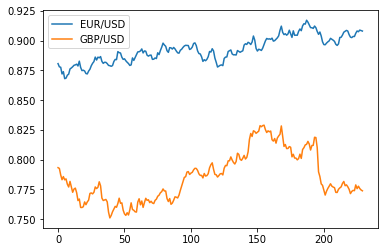

In [19]:
plt.plot(eur, label='EUR/USD')
plt.plot(gbp, label='GBP/USD')
plt.legend()

### Univariate Stochastic Volatility 

In [22]:
class StochVol(ssm.StateSpaceModel):
    def PX0(self):  # Distribution of X_0
        return dists.Normal(loc=self.mu, scale=self.sigma / np.sqrt(1. - self.rho**2))
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
        return dists.Normal(loc=self.mu + self.rho * (xp - self.mu), scale=self.sigma)
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        return dists.Normal(loc=0., scale=np.exp(x))

In [23]:
# my_model = StochVol(mu=-1., rho=.9, sigma=.1) 

### (Bayesian) Parameter estimation

In [20]:
# Prior
prior_dict = {'mu':dists.Normal(),
              'sigma': dists.Gamma(a=1., b=1.),
              'rho':dists.Beta(9., 1.)}
my_prior = dists.StructDist(prior_dict)

In [21]:
from particles import mcmc  # where the MCMC algorithms (PMMH, Particle Gibbs, etc) live

In [24]:
pmmh = mcmc.PMMH(ssm_cls=StochVol, prior=my_prior, data=eur, Nx=100, niter = 2000)
pmmh.run()  # Warning: takes a few seconds

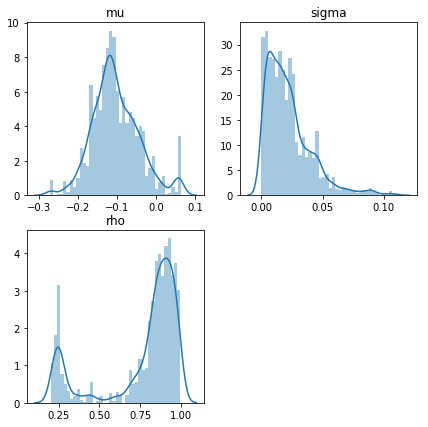

In [27]:
# plot the marginals
burnin = 100  # discard the 100 first iterations
plt.figure(figsize=(7,7))
for i, param in enumerate(prior_dict.keys()):
    plt.subplot(2, 2, i+1)
    sb.distplot(pmmh.chain.theta[param][burnin:], 40)
    plt.title(param)